In [1]:
# HIDE CODE

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import warnings
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(286)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# HIDE CODE

az.style.use("arviz-darkgrid")
# Import firingrate data
srrs2 = pd.read_csv(pm.get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
# Select a subset of "mice" from Minnesota
srrs_mn = srrs2[srrs2.state=='MN'].copy()

In [3]:
# HIDE CODE

srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [4]:
# HIDE CODE

print(srrs_mn.columns,srrs_mn.shape)
print(cty_mn.columns,cty_mn.shape)

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips'],
      dtype='object') (919, 26)
Index(['stfips', 'ctfips', 'st', 'cty', 'lon', 'lat', 'Uppm', 'fips'], dtype='object') (89, 8)


In [5]:
# HIDE CODE

srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [6]:
# HIDE CODE

srrs_mn['Uppm'].unique().shape,srrs_mn['activity'].unique().shape
#plt.scatter(srrs_mn['Uppm'],srrs_mn['activity'])

((85,), (156,))

In [7]:
# HIDE CODE

# Rename environmental variables to represent 
# what we think of as a neuroscience example
srrs_mn.rename({'floor':'no_stim','basement':'stim','county':'mouse',
                'activity':'firingrate'},axis=1,inplace=True)

In [8]:
# HIDE CODE

srrs_mn.head()

idnum state state2  stfips    zip  region  typebldg  no_stim  room stim  \
0   5081    MN     MN      27  55735       5         1        1     3    N   
1   5082    MN     MN      27  55748       5         1        0     4    Y   
2   5083    MN     MN      27  55748       5         1        0     4    Y   
3   5084    MN     MN      27  56469       5         1        0     4    Y   
4   5085    MN     MN      27  55011       3         1        0     4    Y   

   ...  stopdt firingrate  pcterr        adjwt  dupflag  zipflag  cntyfips  \
0  ...   12288        2.2     9.7  1146.499190        1        0         1   
1  ...   12088        2.2    14.5   471.366223        0        0         1   
2  ...   21188        2.9     9.6   433.316718        0        0         1   
3  ...  123187        1.0    24.3   461.623670        0        0         1   
4  ...   13088        3.1    13.8   433.316718        0        0         3   

                  mouse   fips      Uppm  
0  AITKIN                27001  0.502054  
1  AITKIN                27001  0.502054  
2  AITKIN                27001  0.502054  
3  AITKIN                27001  0.502054  
4  ANOKA                 27003  0.428565  

[5 rows x 27 columns]

In [9]:
# HIDE CODE

srrs_mn.mouse = srrs_mn.mouse.map(str.strip)
mn_mice = srrs_mn.mouse.unique()
n_mice = len(mn_mice)
mouse_lookup = dict(zip(mn_mice, range(n_mice)))

In [10]:
# HIDE CODE

mouse = srrs_mn['mouse_code'] = srrs_mn.mouse.replace(mouse_lookup).values
firingrate = srrs_mn.firingrate
srrs_mn['log_firingrate'] = log_firingrate = np.log(firingrate + 0.1).values
no_stim = srrs_mn.no_stim.values

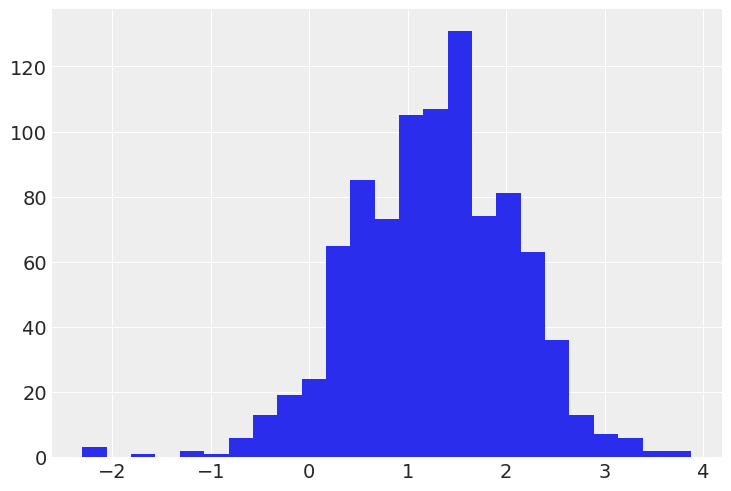

In [11]:
# HIDE CODE

srrs_mn.log_firingrate.hist(bins=25);

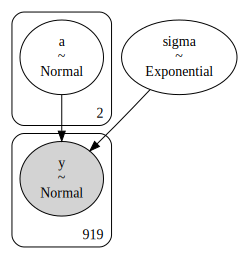

In [12]:
# HIDE CODE

with pm.Model() as pooled_model:
    a = pm.Normal('a', 0., sigma=10., shape=2)
    
    theta = a[no_stim]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    
pm.model_to_graphviz(pooled_model)

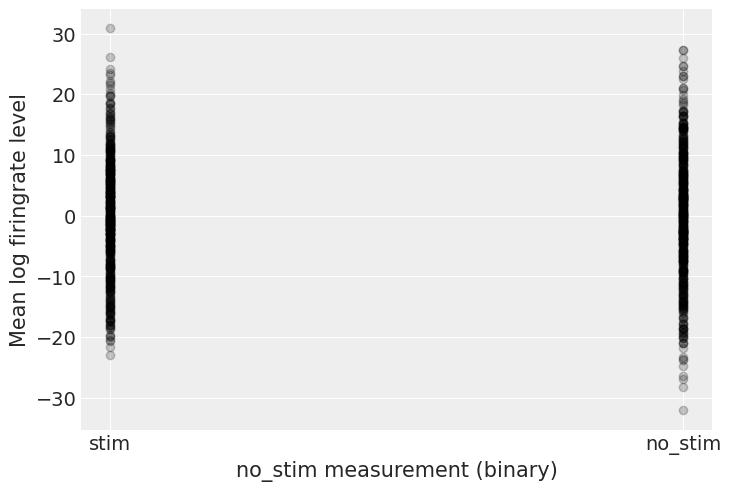

In [13]:
# HIDE CODE

with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

plt.plot(
    [0, 1], 
    [prior_checks["a"][:, 0], prior_checks["a"][:, 1]],
    "ok",
    alpha=0.2)
plt.xlabel("no_stim measurement (binary)")
plt.xticks([0,1], ["stim", "no_stim"])
plt.ylabel("Mean log firingrate level");

In [14]:
# HIDE CODE

with pooled_model:
    pooled_trace = pm.fit()

Finished [100%]: Average Loss = 1,149.9


In [15]:
 
# HIDE CODE

with pooled_model:
    start = pm.find_MAP()
    pooled_trace = pm.sample(1000, pm.NUTS(scaling=start), start=start, random_seed=RANDOM_SEED)
az.summary(pooled_trace, round_to=2)

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0]   1.36  0.03    1.31     1.42        0.0      0.0   2773.13  2762.79   
a[1]   0.78  0.06    0.66     0.90        0.0      0.0   2506.71  2506.71   
sigma  0.79  0.02    0.76     0.83        0.0      0.0   2982.40  2982.40   

       ess_bulk  ess_tail  r_hat  
a[0]    2775.68   1365.32    1.0  
a[1]    2532.78   1571.47    1.0  
sigma   2960.79   1393.63    1.0

In [16]:
# HIDE CODE

with pooled_model:
    pooled_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
az.summary(pooled_trace, round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0]   1.36  0.03    1.31     1.42        0.0      0.0   2967.47  2962.31   
a[1]   0.78  0.07    0.65     0.90        0.0      0.0   2616.90  2544.65   
sigma  0.79  0.02    0.76     0.82        0.0      0.0   2464.64  2464.64   

       ess_bulk  ess_tail  r_hat  
a[0]    2912.22   1235.99    1.0  
a[1]    2644.19   1543.78    1.0  
sigma   2489.01   1348.90    1.0

In [17]:
# HIDE CODE

with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=RANDOM_SEED)["y"]

a_stim, a_no_stim = pooled_trace["a"].mean(axis=0)
firingrate_stim, firingrate_no_stim = ppc[:, 1], ppc[:, 0] # we know that no_stim=0/1 at these columns

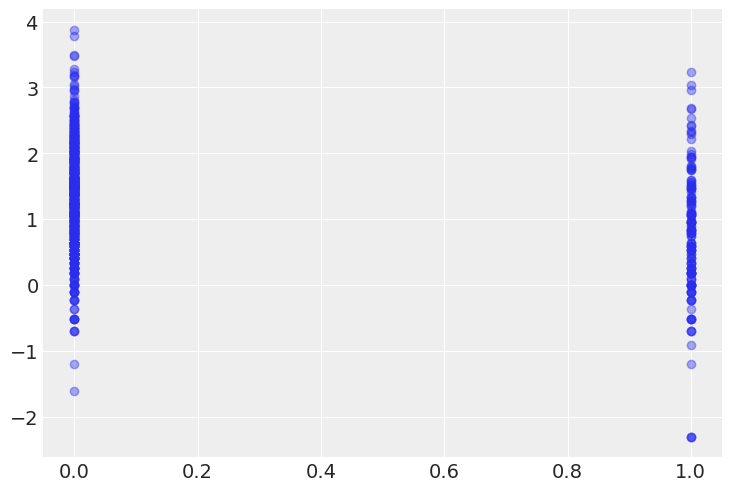

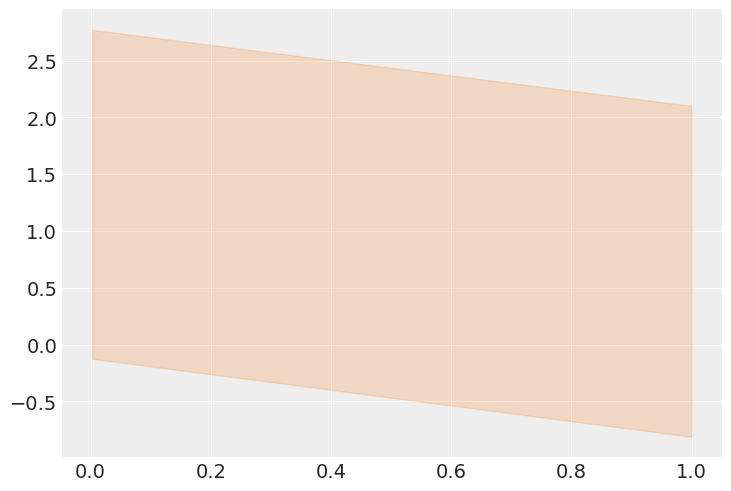

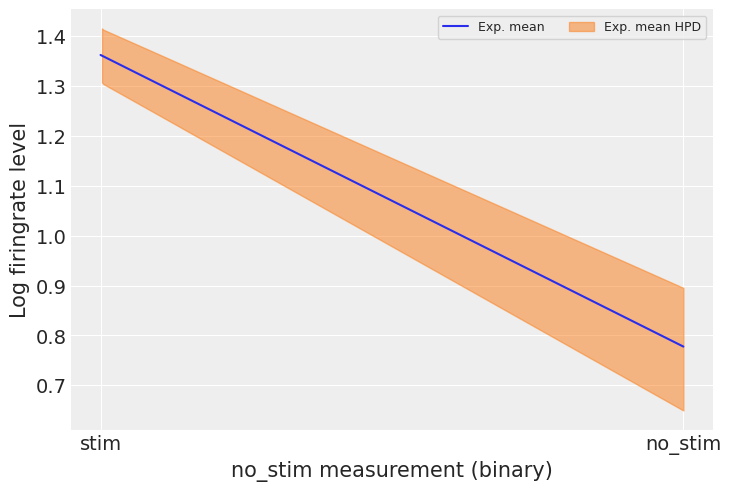

In [18]:
# HIDE CODE

plt.scatter(no_stim, log_firingrate, label="Observations", alpha=0.4)

az.plot_hpd(
    [0, 1], 
    np.asarray([firingrate_stim, firingrate_no_stim]).T, 
    fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of firingrate levels"}
)
az.plot_hpd(
    [0, 1], 
    pooled_trace["a"], 
    fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"}
)
plt.plot([0, 1], [a_stim, a_no_stim], label="Exp. mean")

plt.xticks([0,1], ["stim", "no_stim"])
plt.xlabel("no_stim measurement (binary)")
plt.ylabel("Log firingrate level")
plt.legend(ncol=2, fontsize=9, frameon=True);

In [19]:
# HIDE CODE

n_mice,no_stim.shape,log_firingrate.shape

(85, (919,), (919,))

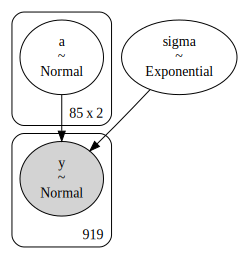

In [20]:
# HIDE CODE

# updated version:
with pm.Model() as unpooled_model:
    a = pm.Normal('a', 0., sigma=10., shape=(n_mice, 2))
    
    theta = a[mouse, no_stim]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)

pm.model_to_graphviz(unpooled_model)

In [21]:
# HIDE CODE

with unpooled_model:
    unpooled_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 11 seconds.


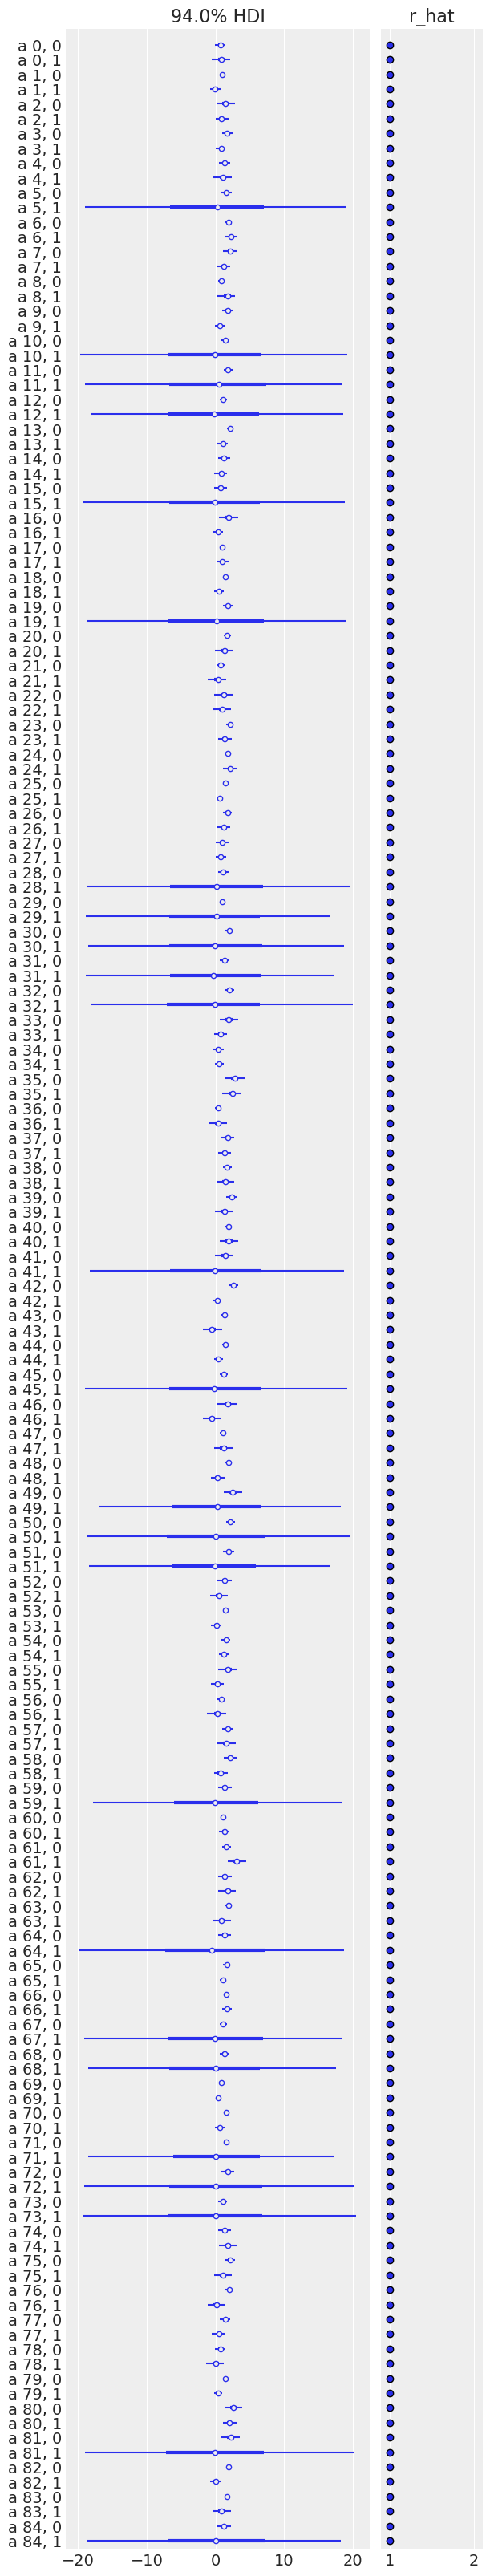

In [22]:
# HIDE CODE

az.plot_forest(unpooled_trace, var_names=['a'], figsize=(6, 32), r_hat=True, combined=True);

In [23]:
# HIDE CODE

a_stim_unpooled, a_no_stim_unpooled = unpooled_trace["a"][:, :, 0], unpooled_trace["a"][:, :, 1]
unpooled_stim = pd.DataFrame.from_dict(
                        {
                            "stim": a_stim_unpooled.mean(0), 
                            "low": az.hpd(a_stim_unpooled)[:, 0], 
                            "high": az.hpd(a_stim_unpooled)[:, 1]
                        }, 
                        orient="index", 
                        columns=mn_mice
                    ).T.sort_values(by="stim")
unpooled_no_stim = pd.DataFrame.from_dict(
                    {
                        "no_stim": a_no_stim_unpooled.mean(0),
                        "low": az.hpd(a_no_stim_unpooled)[:, 0], 
                        "high": az.hpd(a_no_stim_unpooled)[:, 1]
                    }, 
                    orient="index", 
                    columns=mn_mice
                ).T.sort_values(by="no_stim")

/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if __name__ == '__main__':


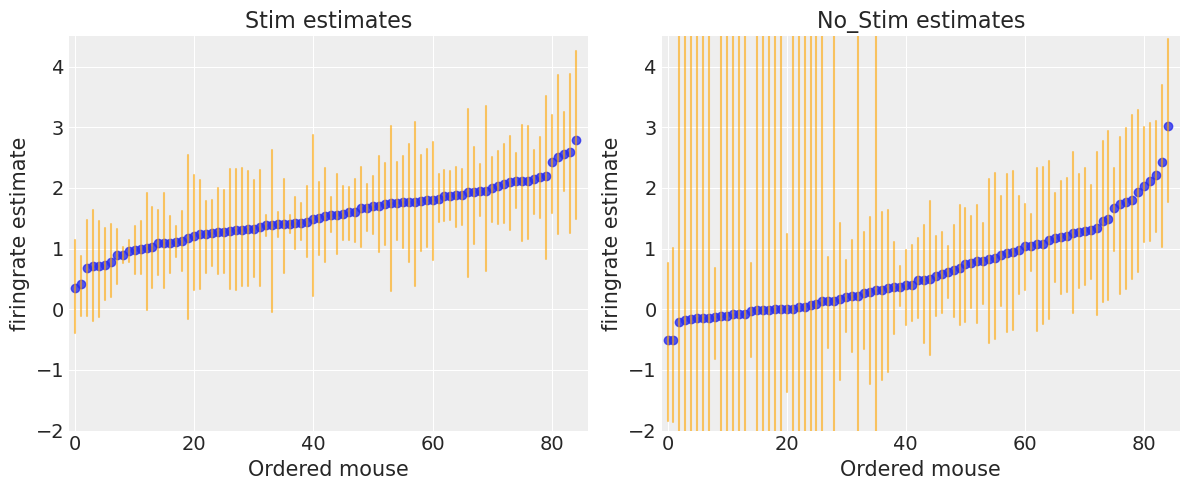

In [24]:
# HIDE CODE

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, estimates, level in zip(axes, [unpooled_stim, unpooled_no_stim], ["stim", "no_stim"]):    
    for i, l, h in zip(range(n_mice), estimates.low.values, estimates.high.values):
        ax.plot([i, i], [l, h], alpha=0.6, c='orange')
    ax.scatter(range(n_mice), estimates[level], alpha=0.8)
    ax.set(title=f"{level.title()} estimates", xlabel="Ordered mouse", xlim=(-1, 86), ylabel="firingrate estimate", ylim=(-2, 4.5))
plt.tight_layout();

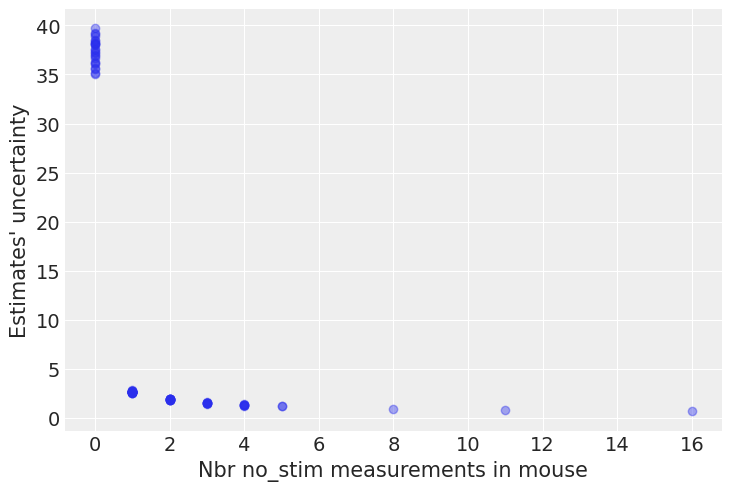

In [25]:
# HIDE CODE

n_no_stim_meas = srrs_mn.groupby("mouse").sum().no_stim
uncertainty = (unpooled_no_stim.high - unpooled_no_stim.low).sort_index() # sort index to match counties alphabetically

plt.plot(n_no_stim_meas, uncertainty, 'o', alpha=.4)
plt.xlabel("Nbr no_stim measurements in mouse")
plt.ylabel("Estimates' uncertainty");

/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


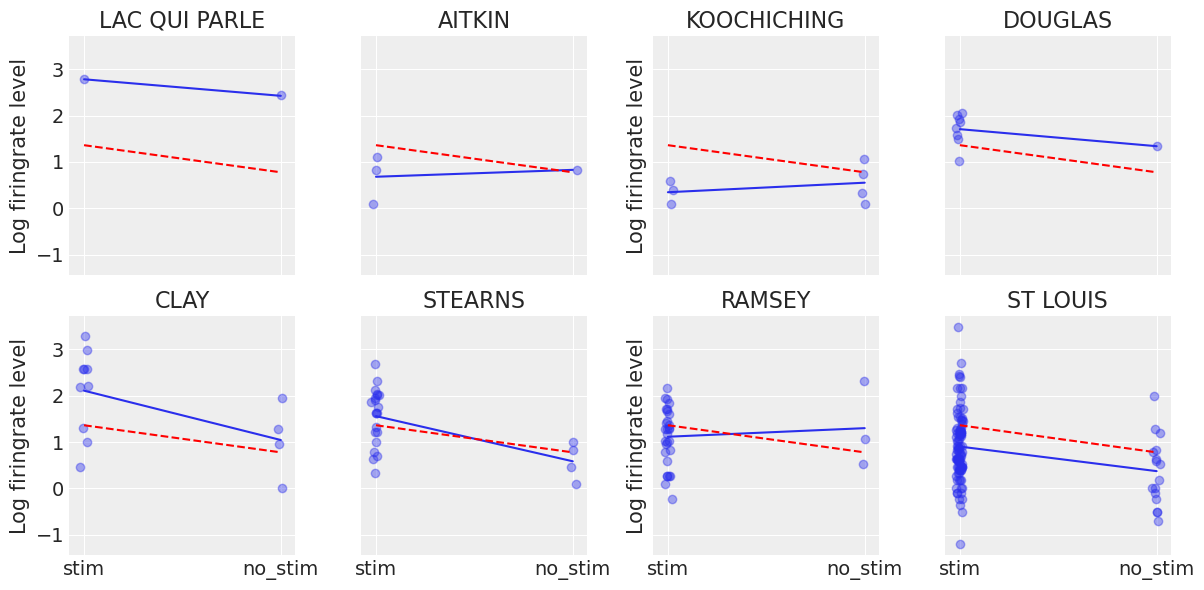

In [26]:
# HIDE CODE

# These mice were named as counties in Minnesota, how curious
SAMPLE_mice = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel() 
for i, c in enumerate(SAMPLE_mice):
    x = srrs_mn.no_stim[srrs_mn.mouse==c]
    y = srrs_mn.log_firingrate[srrs_mn.mouse==c]
    
    # plot obs:
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # plot both models:
    axes[i].plot([0, 1], [unpooled_stim.loc[c, "stim"] , unpooled_no_stim.loc[c, "no_stim"]])
    axes[i].plot([0, 1], [a_stim, a_no_stim], "r--")
    
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["stim", "no_stim"])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel("Log firingrate level")
plt.tight_layout();

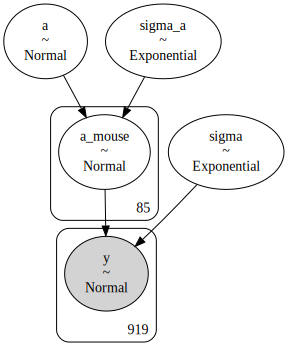

In [27]:
# HIDE CODE

with pm.Model() as partial_pooling:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    
    # Expected value per mouse:
    theta = a_mouse[mouse]
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(partial_pooling)

In [28]:
# HIDE CODE

with partial_pooling:
    partial_pooling_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, a_mouse, sigma_a, a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 8 seconds.


The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, a_mouse]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 6 seconds.


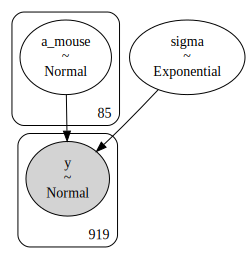

In [29]:
# HIDE CODE

with pm.Model() as unpooled_bis:
    a_mouse = pm.Normal('a_mouse', 0., sigma=10., shape=n_mice)
    
    theta = a_mouse[mouse]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    
    unpooled_trace_bis = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
pm.model_to_graphviz(unpooled_bis)

/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


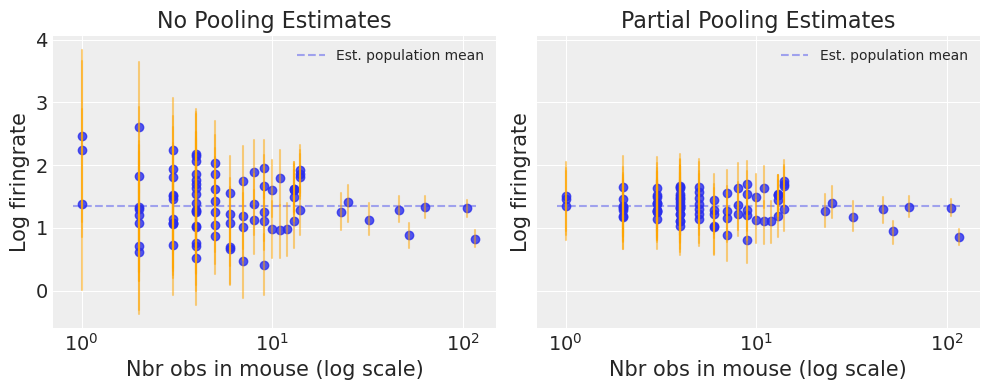

In [30]:
# HIDE CODE

N_mouse = srrs_mn.groupby("mouse")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes, 
    [unpooled_trace_bis["a_mouse"], partial_pooling_trace["a_mouse"]], 
    ["no pooling", "partial pooling"]
):
    ax.hlines(
        partial_pooling_trace["a"].mean(), 
        0.9, 
        max(N_mouse) + 1, 
        alpha=0.4, 
        ls="--", 
        label="Est. population mean"
    )
    for n, l, h in zip(
        N_mouse, 
        az.hpd(trace)[:, 0], 
        az.hpd(trace)[:, 1]
    ):
        ax.plot([n, n], [l, h], alpha=0.5, c="orange")
    ax.scatter(N_mouse, trace.mean(0), alpha=0.8)
    ax.set(
        title=f"{level.title()} Estimates", 
        xlabel="Nbr obs in mouse (log scale)", 
        xscale="log", 
        ylabel="Log firingrate"
    )
    ax.legend(fontsize=10)
plt.tight_layout();

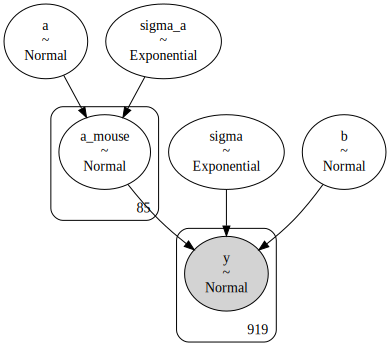

In [31]:
# HIDE CODE

with pm.Model() as varying_intercept:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=10.)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept)

In [32]:
# HIDE CODE

with varying_intercept:
    varying_intercept_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, b, a_mouse, sigma_a, a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 8 seconds.


The number of effective samples is smaller than 25% for some parameters.


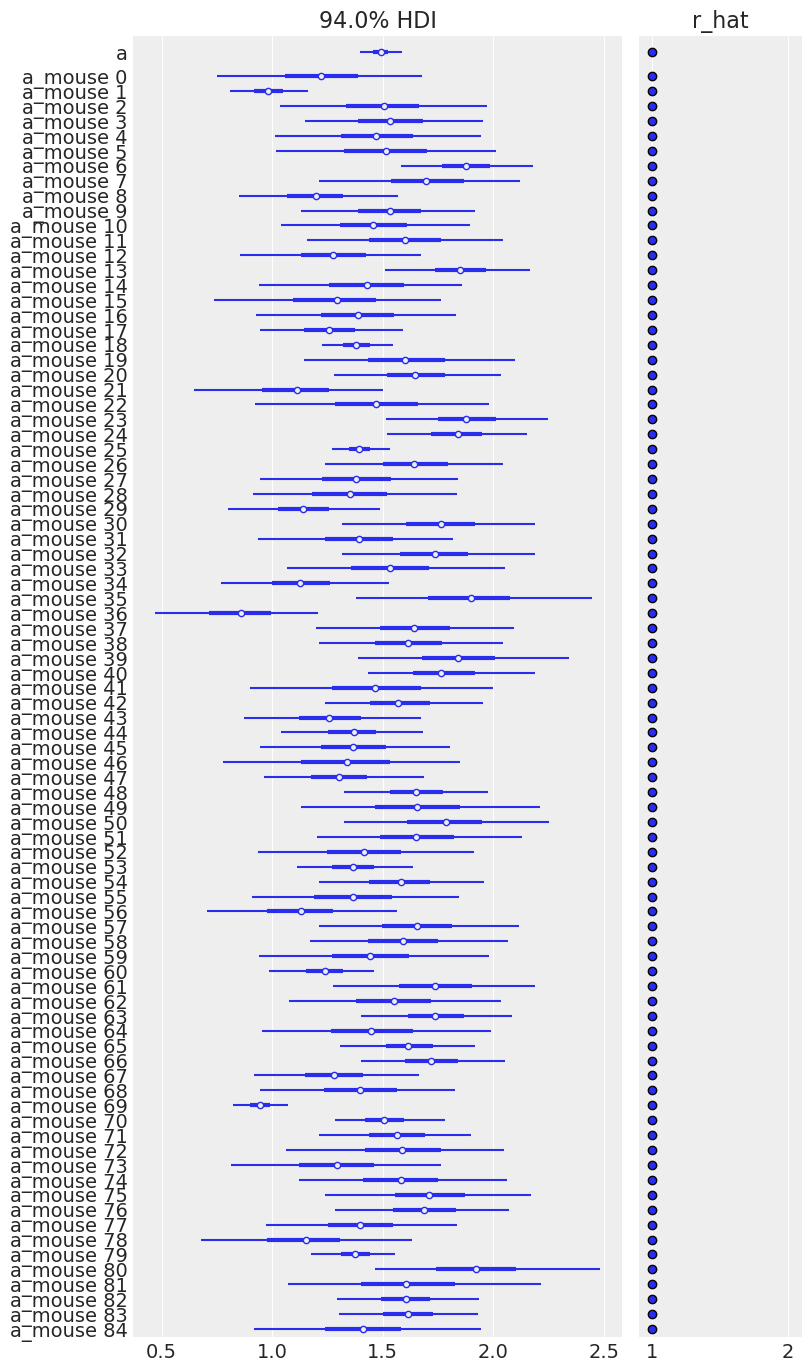

In [33]:
# HIDE CODE

az.plot_forest(varying_intercept_trace, var_names=["a", "a_mouse"], r_hat=True, combined=True);

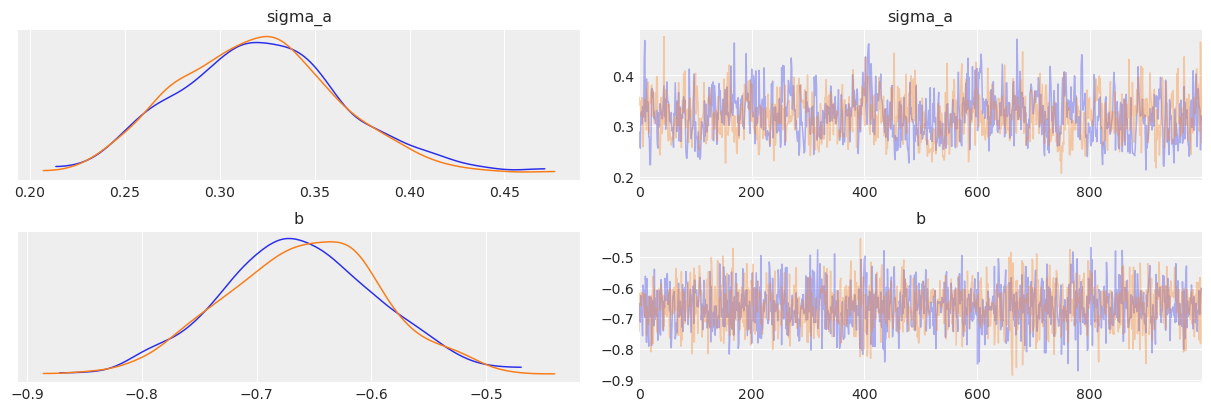

In [34]:
# HIDE CODE

az.plot_trace(varying_intercept_trace, var_names=["sigma_a", "b"]);

In [35]:
# HIDE CODE

az.summary(varying_intercept_trace, var_names=["a", "sigma_a", "b", "sigma"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a        1.49  0.05    1.40     1.59        0.0      0.0   1253.14  1251.08   
sigma_a  0.32  0.04    0.24     0.40        0.0      0.0    375.89   375.89   
b       -0.66  0.07   -0.79    -0.53        0.0      0.0   1836.87  1831.31   
sigma    0.73  0.02    0.69     0.76        0.0      0.0   2313.87  2313.87   

         ess_bulk  ess_tail  r_hat  
a         1256.29   1317.13    1.0  
sigma_a    366.13    711.18    1.0  
b         1844.85   1424.33    1.0  
sigma     2274.12   1552.95    1.0

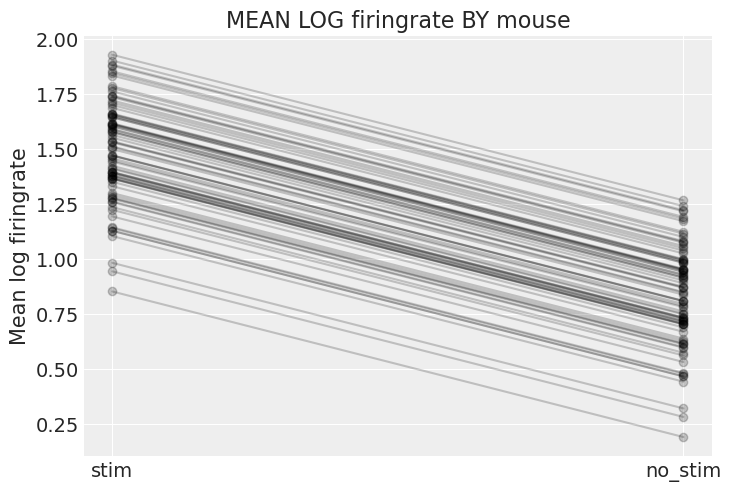

In [36]:
# HIDE CODE

xvals = np.arange(2)
avg_a_mouse = varying_intercept_trace["a_mouse"].mean(0)
avg_b = varying_intercept_trace["b"].mean()

for a_c in avg_a_mouse:
    plt.plot(xvals, a_c + avg_b * xvals, 'ko-', alpha=0.2)
plt.xticks([0,1], ["stim", "no_stim"])
plt.ylabel("Mean log firingrate")
plt.title("MEAN LOG firingrate BY mouse");

/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


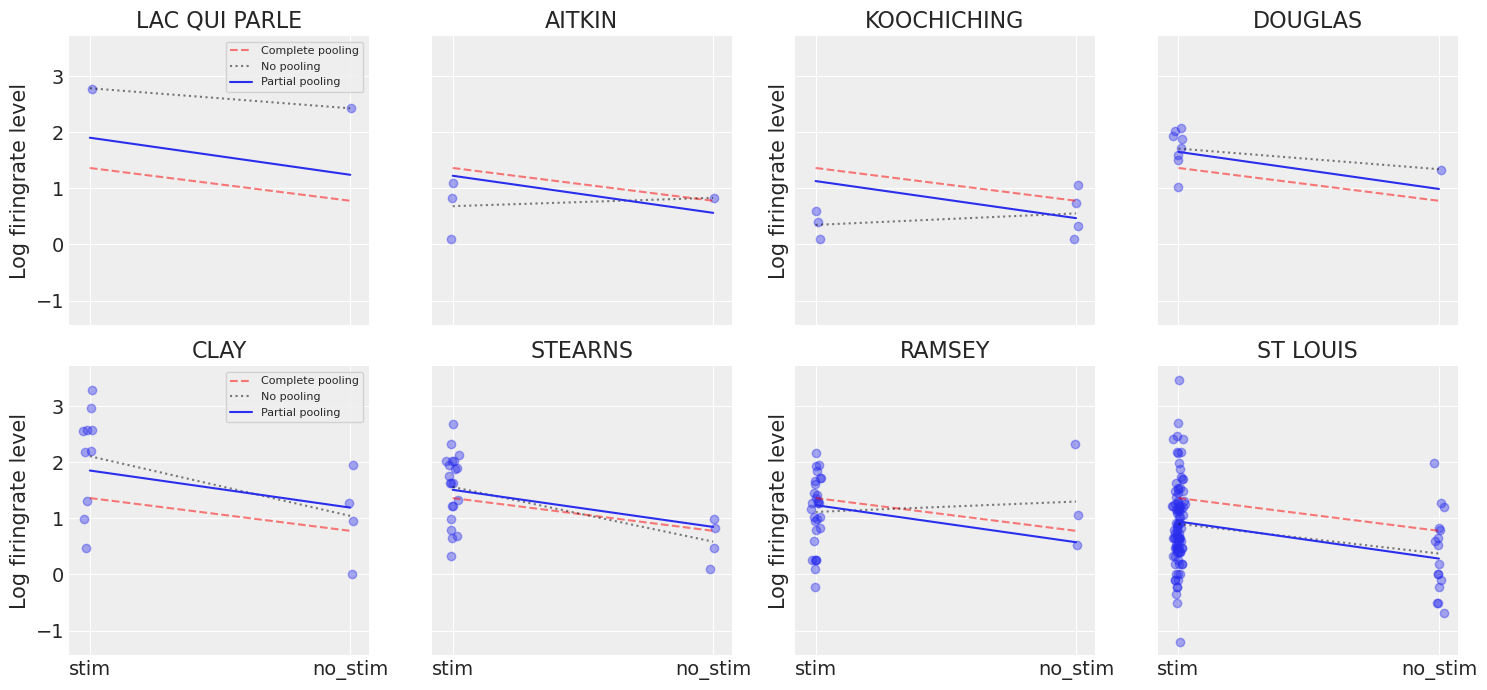

In [37]:
# HIDE CODE

fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharey=True, sharex=True)
axes = axes.ravel()
for i, c in enumerate(SAMPLE_mice):
    x = srrs_mn.no_stim[srrs_mn.mouse==c]
    y = srrs_mn.log_firingrate[srrs_mn.mouse==c]
    
    # plot obs:
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    # complete-pooling model:
    axes[i].plot([0, 1], [a_stim, a_no_stim], "r--", alpha=0.5, label="Complete pooling")
    # no-pooling model:
    axes[i].plot(
        [0, 1], 
        [unpooled_stim.loc[c, "stim"] , unpooled_no_stim.loc[c, "no_stim"]],
        "k:",
        alpha=0.5,
        label="No pooling"
    )
    # partial-pooling model:
    axes[i].plot(
        [0, 1], 
        [avg_a_mouse[mouse_lookup[c]], avg_a_mouse[mouse_lookup[c]] + avg_b],
        label="Partial pooling"
    )
    
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["stim", "no_stim"])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel("Log firingrate level")
    if not i%4:
        axes[i].legend(fontsize=8, frameon=True)
plt.tight_layout();

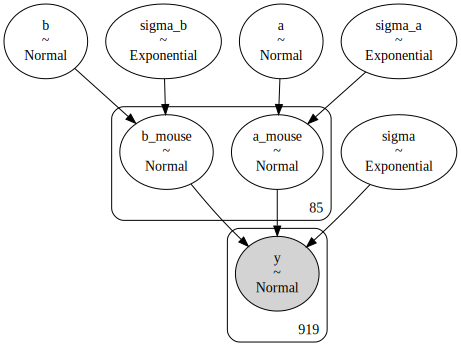

In [38]:
# HIDE CODE

with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=5.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.)
    sigma_b = pm.Exponential('sigma_b', 0.5)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Varying slopes:
    b_mouse = pm.Normal('b_mouse', mu=b, sigma=sigma_b, shape=n_mice)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b_mouse[mouse] * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept_slope)

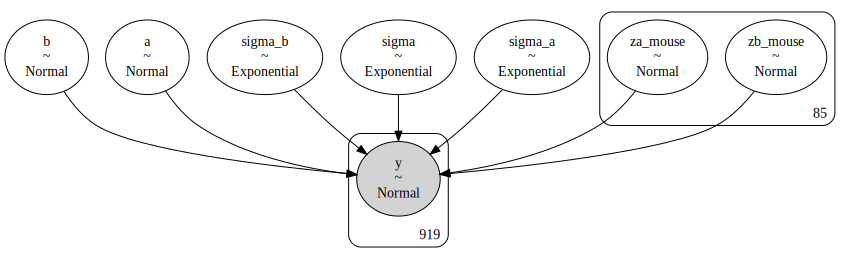

In [39]:
# HIDE CODE

with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=5.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.)
    sigma_b = pm.Exponential('sigma_b', 0.5)
    
    # Varying intercepts:
    za_mouse = pm.Normal('za_mouse', mu=0., sigma=1., shape=n_mice)
    # Varying slopes:
    zb_mouse = pm.Normal('zb_mouse', mu=0., sigma=1., shape=n_mice)
    
    # Expected value per mouse:
    theta = (a + za_mouse[mouse] * sigma_a) + (b + zb_mouse[mouse] * sigma_b) * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept_slope)

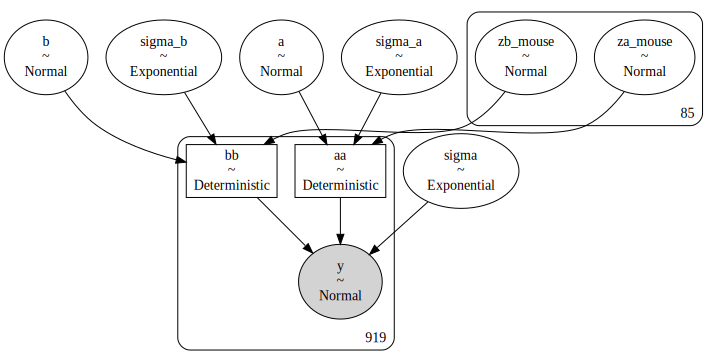

In [40]:
# HIDE CODE

with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=5.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.)
    sigma_b = pm.Exponential('sigma_b', 0.5)
    
    # Varying intercepts:
    za_mouse = pm.Normal('za_mouse', mu=0., sigma=1., shape=n_mice)
    # Varying slopes:
    zb_mouse = pm.Normal('zb_mouse', mu=0., sigma=1., shape=n_mice)
    
    # Expected value per mouse:
    aa=pm.Deterministic('aa', a + za_mouse[mouse] * sigma_a)
    bb = pm.Deterministic('bb', b + zb_mouse[mouse] * sigma_b)
    theta = aa + bb * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept_slope)

In [41]:
# HIDE CODE

with varying_intercept_slope:    
    varying_intercept_slope_trace = pm.sample(1000, tune=6000, target_accept=0.99, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, zb_mouse, za_mouse, sigma_b, b, sigma_a, a]


Sampling 2 chains for 6_000 tune and 1_000 draw iterations (12_000 + 2_000 draws total) took 135 seconds.


The number of effective samples is smaller than 25% for some parameters.


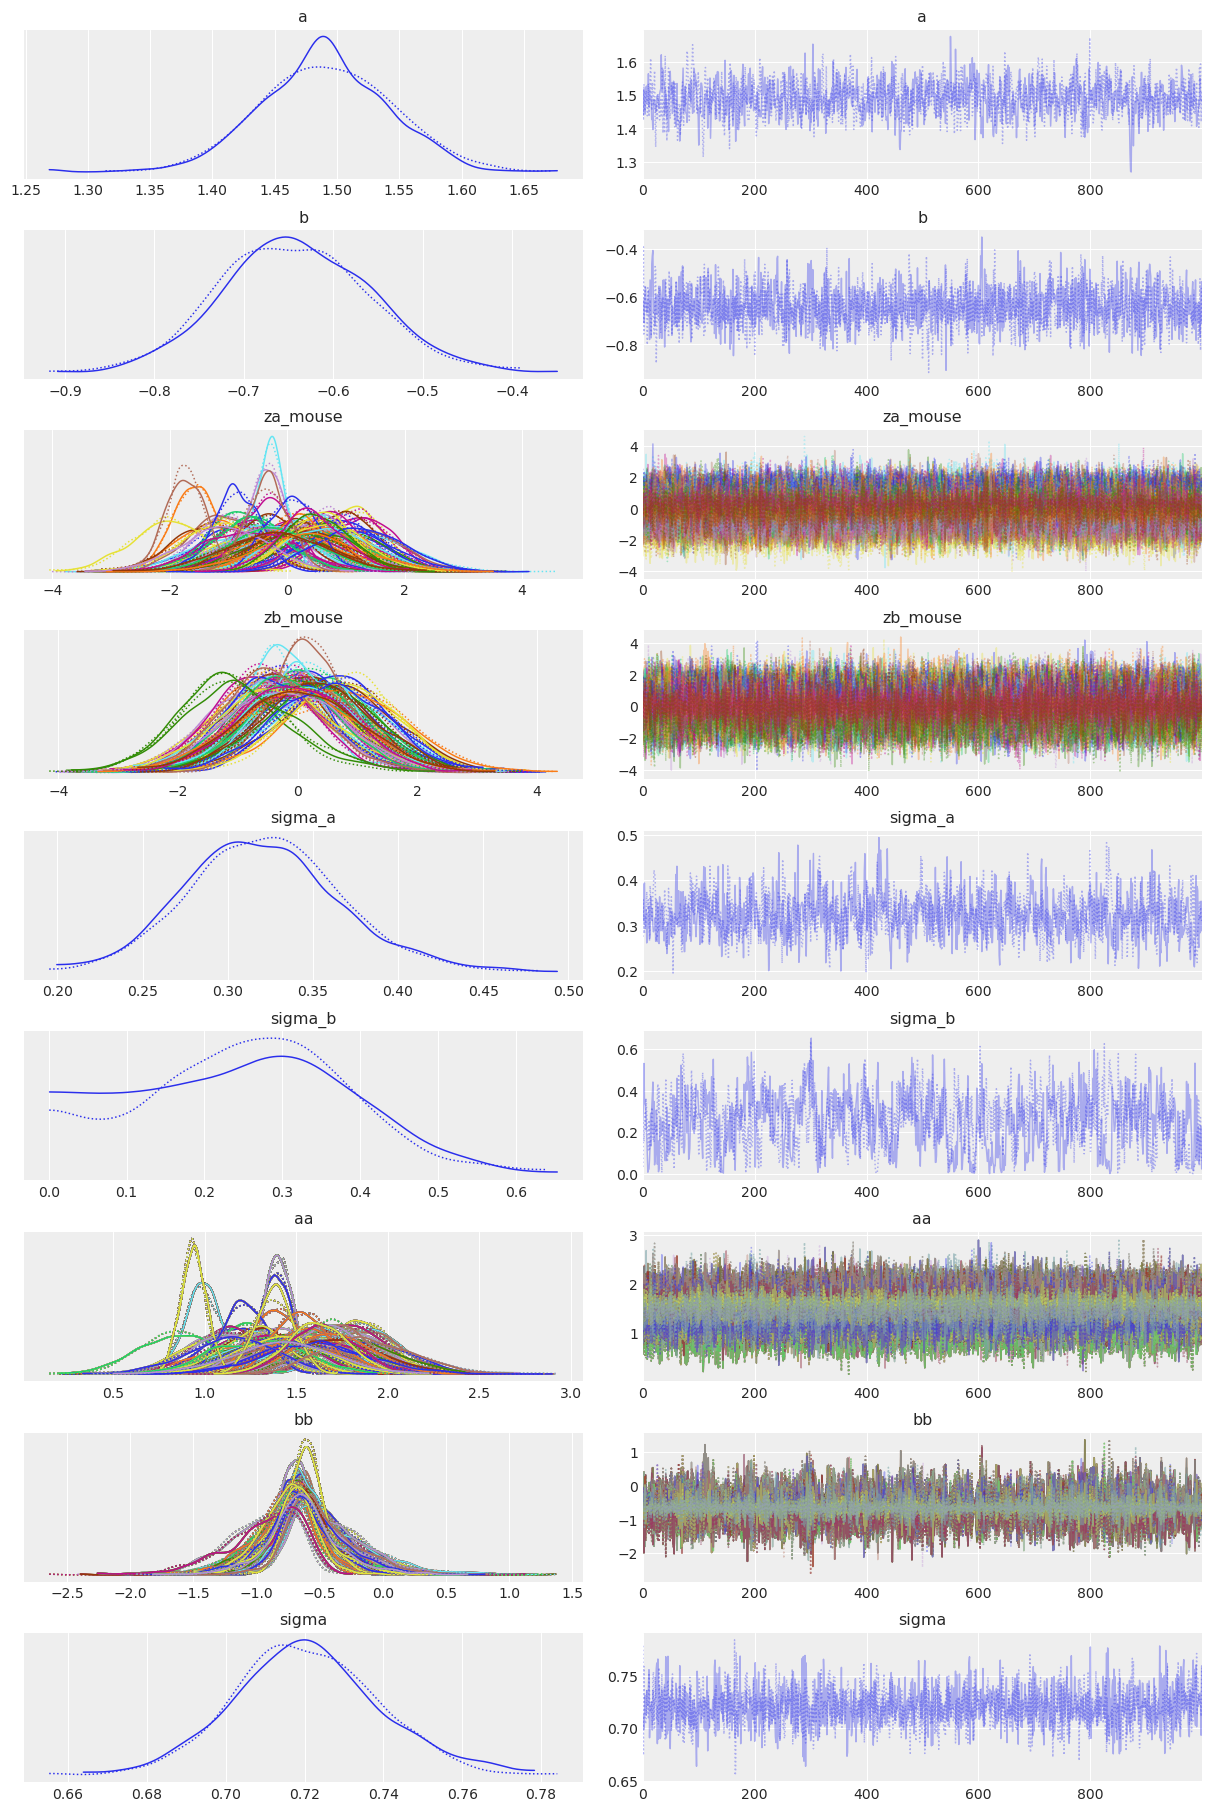

In [42]:
# HIDE CODE

az.plot_trace(varying_intercept_slope_trace, compact=True);

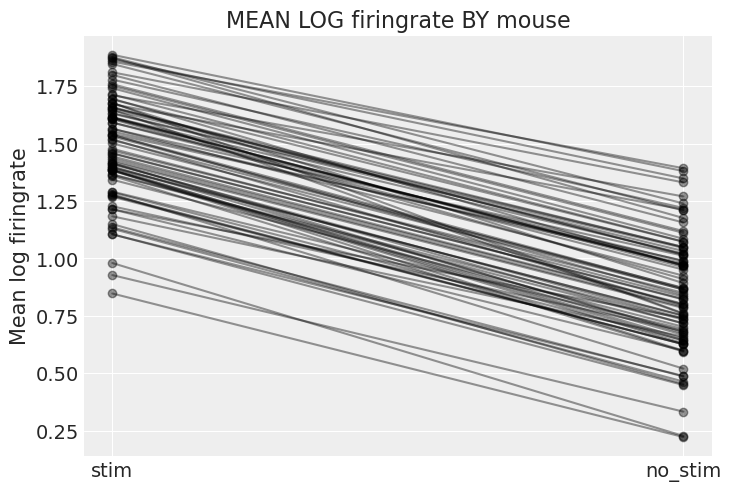

In [43]:
# HIDE CODE

xvals = np.arange(2)
avg_a_mouse = (
    varying_intercept_slope_trace["a"].mean() 
    + varying_intercept_slope_trace["za_mouse"].mean(0) 
    * varying_intercept_slope_trace["sigma_a"].mean()
)
avg_b_mouse = (
    varying_intercept_slope_trace["b"].mean() 
    + varying_intercept_slope_trace["zb_mouse"].mean(0) 
    * varying_intercept_slope_trace["sigma_b"].mean()
)

for a_c, b_c in zip(avg_a_mouse, avg_b_mouse):
    plt.plot(xvals, a_c + b_c * xvals, 'ko-', alpha=0.4)
plt.xticks([0,1], ["stim", "no_stim"])
plt.ylabel("Mean log firingrate")
plt.title("MEAN LOG firingrate BY mouse");

/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/arviz/plots/plot_utils.py:483: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (2013) in plot_posterior, generating only 40 plots
  UserWarning,


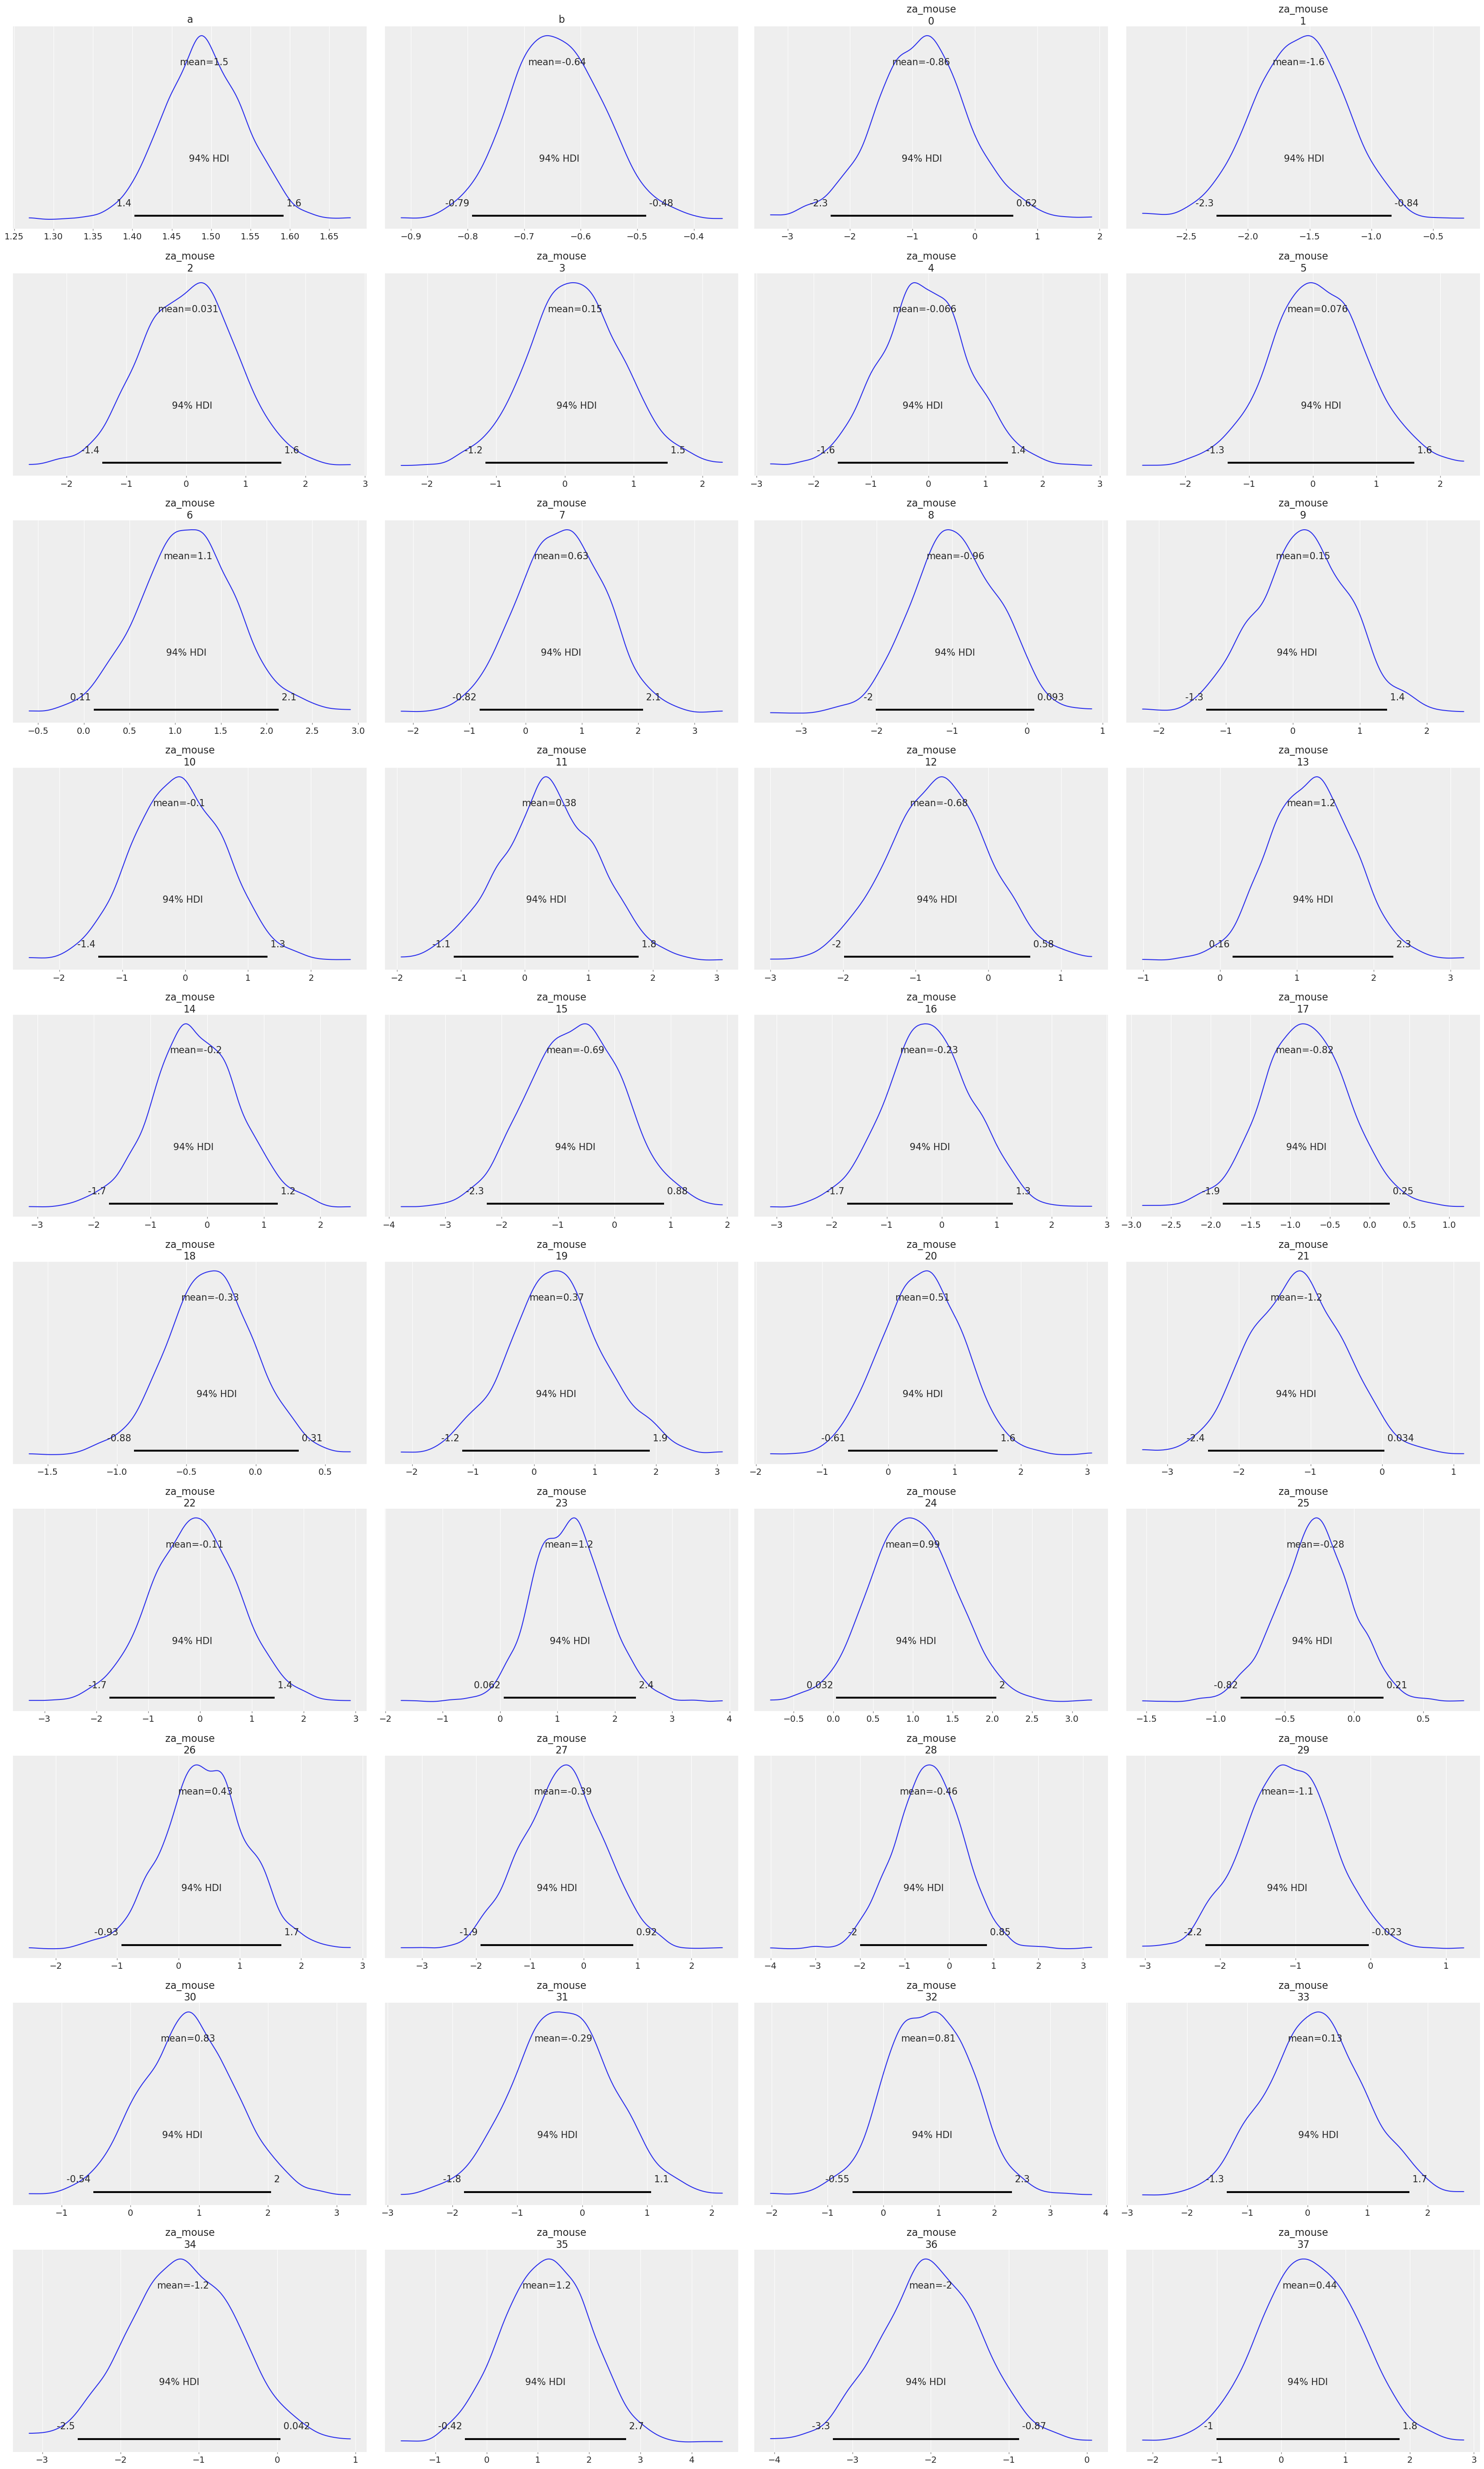

In [44]:
# HIDE CODE

_=az.plot_posterior(varying_intercept_slope_trace)

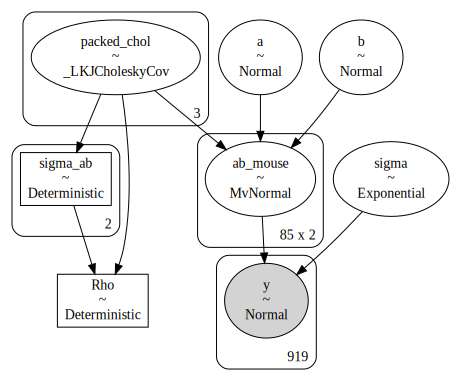

In [45]:
# HIDE CODE

with pm.Model() as covariation_intercept_slope:
    # prior stddev in intercepts & slopes (variation across mice):
    sd_dist = pm.Exponential.dist(0.5)
    packed_chol = pm.LKJCholeskyCov('packed_chol', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    
    # extract standard deviations and rho:
    cov = pm.math.dot(chol, chol.T)
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # prior for average intercept:
    a = pm.Normal('a', mu=0., sigma=5.)
    # prior for average slope:
    b = pm.Normal('b', mu=0., sigma=1.)
    # population of varying effects:
    ab_mouse = pm.MvNormal('ab_mouse', mu=tt.stack([a, b]), chol=chol, shape=(n_mice, 2))
    
    # Expected value per mouse:
    theta = ab_mouse[mouse, 0] + ab_mouse[mouse, 1] * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(covariation_intercept_slope)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, z, b, a, packed_chol]


Sampling 2 chains for 6_000 tune and 1_000 draw iterations (12_000 + 2_000 draws total) took 313 seconds.


The number of effective samples is smaller than 25% for some parameters.


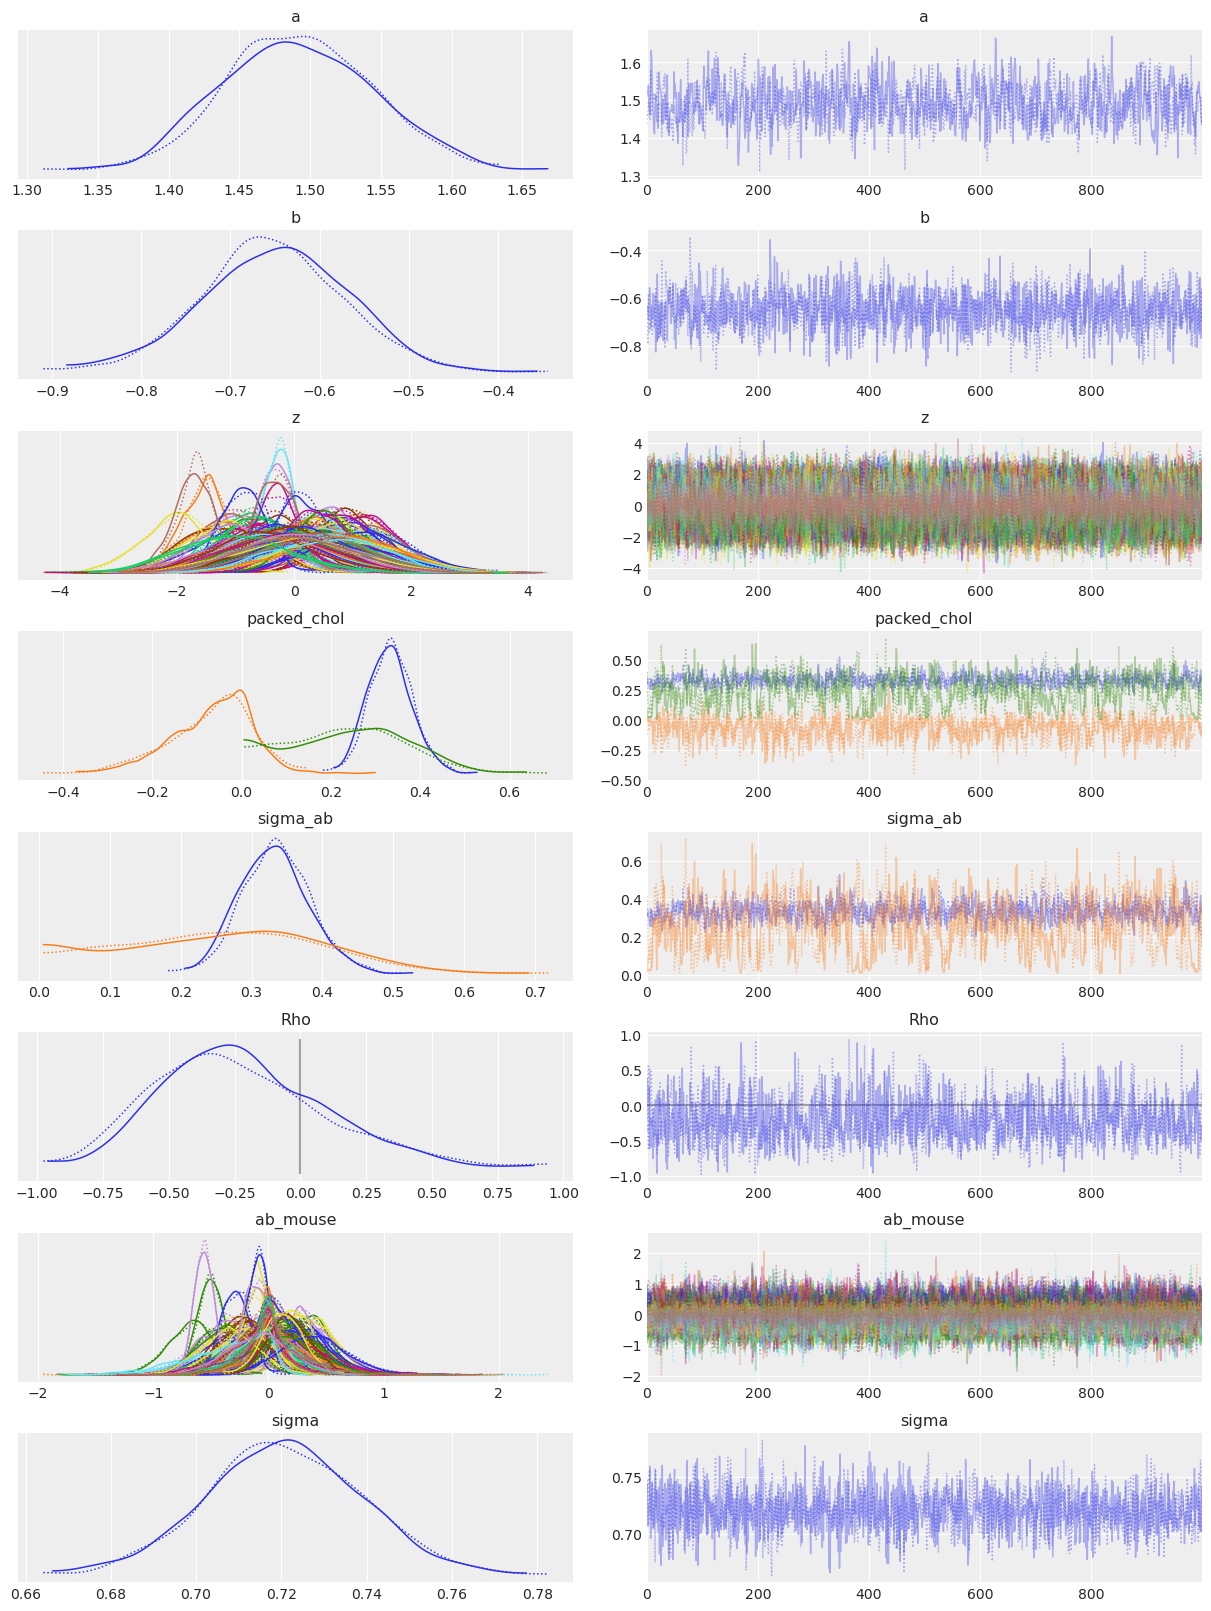

In [46]:
# HIDE CODE

with pm.Model() as covariation_intercept_slope:
    # prior stddev in intercepts & slopes (variation across mice):
    sd_dist = pm.Exponential.dist(0.5)
    packed_chol = pm.LKJCholeskyCov('packed_chol', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    
    # extract standard deviations and rho:
    cov = pm.math.dot(chol, chol.T)
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # prior for average intercept:
    a = pm.Normal('a', mu=0., sigma=5.)
    # prior for average slope:
    b = pm.Normal('b', mu=0., sigma=1.)
    # population of varying effects:
    z = pm.Normal('z', 0., 1., shape=(2, n_mice))
    ab_mouse = pm.Deterministic('ab_mouse', tt.dot(chol, z).T)
    
    # Expected value per mouse:
    theta = a + ab_mouse[mouse, 0] + (b + ab_mouse[mouse, 1]) * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    covariation_intercept_slope_trace = pm.sample(1000, tune=6000, target_accept=0.99, random_seed=RANDOM_SEED)
    
az.plot_trace(covariation_intercept_slope_trace, lines=[("Rho", {}, 0.)], compact=True);

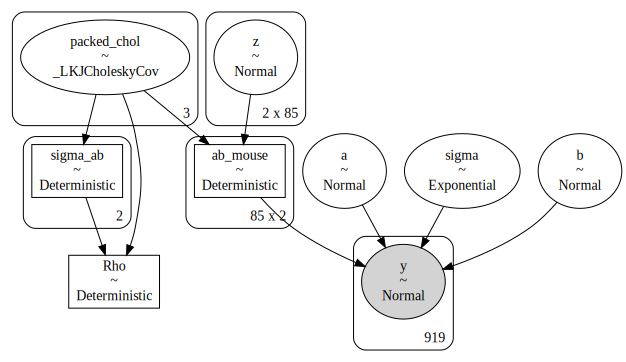

In [47]:
# HIDE CODE

pm.model_to_graphviz(covariation_intercept_slope)

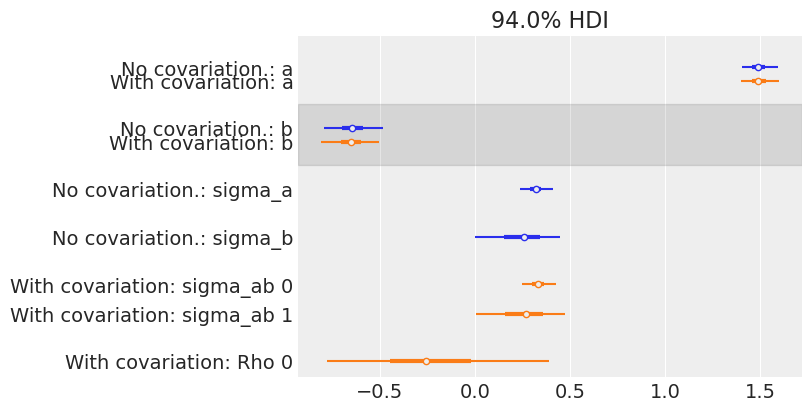

In [48]:
# HIDE CODE

az.plot_forest(
    [varying_intercept_slope_trace, covariation_intercept_slope_trace], 
    model_names=["No covariation.", "With covariation"], 
    var_names=["a", "b", "sigma_a", "sigma_b", "sigma_ab", "Rho"], 
    combined=True,
    figsize=(8, 4)
);

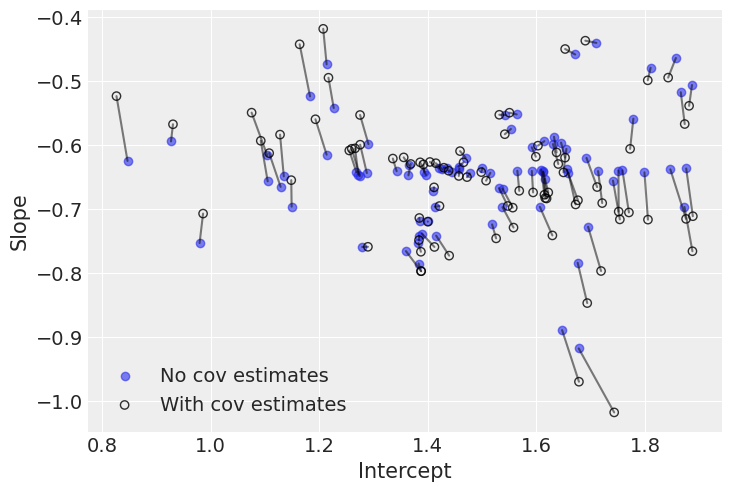

In [49]:
# HIDE CODE

# posterior means of covariation model:
a_mouse_cov = (
    covariation_intercept_slope_trace['a'].mean()
    + covariation_intercept_slope_trace['ab_mouse'].mean(axis=0)[:, 0]
)
b_mouse_cov = (
    covariation_intercept_slope_trace['b'].mean()
    + covariation_intercept_slope_trace['ab_mouse'].mean(axis=0)[:, 1]
)

# plot both and connect with lines
plt.scatter(avg_a_mouse, avg_b_mouse, label="No cov estimates", alpha=0.6)
plt.scatter(a_mouse_cov, b_mouse_cov, facecolors='none', edgecolors='k', lw=1, label="With cov estimates", alpha=0.8)
plt.plot([avg_a_mouse, a_mouse_cov], [avg_b_mouse, b_mouse_cov], 'k-', alpha=.5)
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.legend();

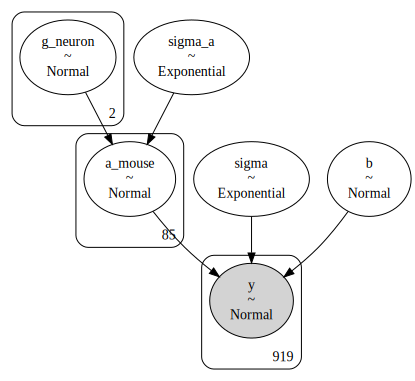

In [50]:
# HIDE CODE

with pm.Model() as hierarchical_intercept:
    # Hyperpriors:
    g = pm.Normal('g_neuron', mu=0., sigma=10., shape=2)
    sigma_a = pm.Exponential('sigma_a', 1.)

    # Varying intercepts velocity model:
    a = g[0] + g[1] * u
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.)

    # Expected value per mouse:
    theta = a_mouse[mouse] + b * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)

    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(hierarchical_intercept)

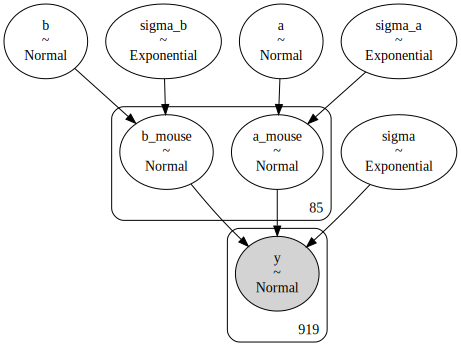

In [51]:
# HIDE CODE

# compare to no velocity:
with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=5.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.)
    sigma_b = pm.Exponential('sigma_b', 0.5)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Varying slopes:
    b_mouse = pm.Normal('b_mouse', mu=b, sigma=sigma_b, shape=n_mice)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b_mouse[mouse] * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept_slope)

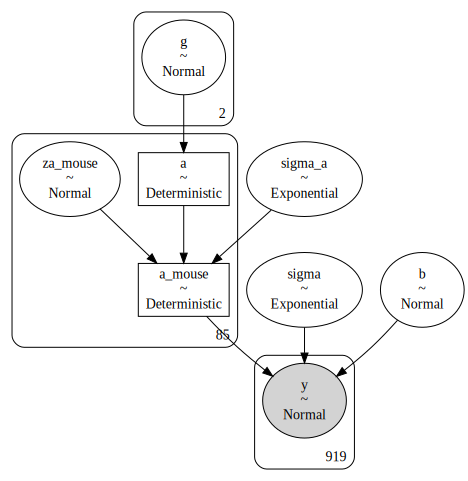

In [52]:
# HIDE CODE

with pm.Model() as hierarchical_intercept:
    # Hyperpriors:
    g = pm.Normal('g', mu=0., sigma=10., shape=2)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts velocity model:
    a = pm.Deterministic('a', g[0] + g[1] * u)
    za_mouse = pm.Normal('za_mouse', mu=0., sigma=1., shape=n_mice)
    a_mouse = pm.Deterministic('a_mouse', a + za_mouse * sigma_a)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    
pm.model_to_graphviz(hierarchical_intercept)

In [53]:
# HIDE CODE

with hierarchical_intercept:    
    hierarchical_intercept_trace = pm.sample(1000, tune=6000, target_accept=0.99, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, b, za_mouse, sigma_a, g]


Sampling 2 chains for 6_000 tune and 1_000 draw iterations (12_000 + 2_000 draws total) took 67 seconds.


The number of effective samples is smaller than 25% for some parameters.


/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


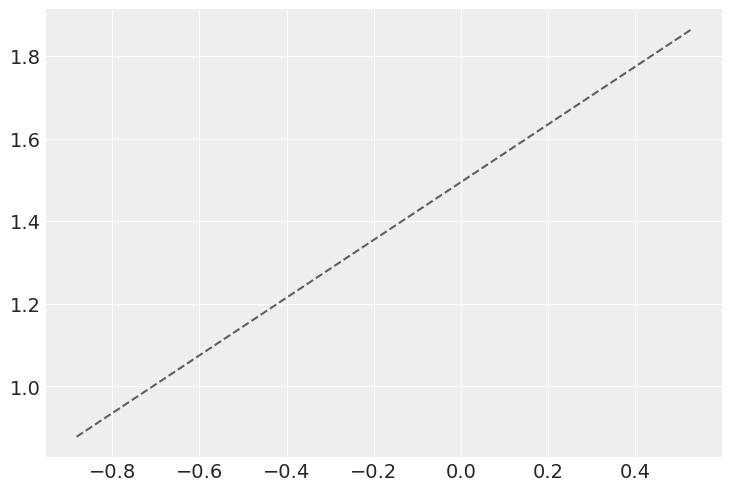

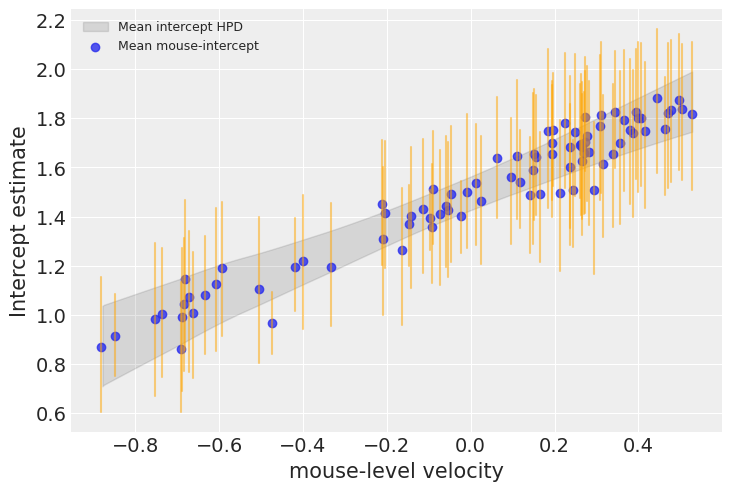

In [54]:
# HIDE CODE

samples = hierarchical_intercept_trace
avg_a = samples['a'].mean(0)
avg_a_mouse = samples['a_mouse'].mean(0)

plt.plot(
    u[np.argsort(u)], 
    avg_a[np.argsort(u)], 
    "k--", 
    alpha=0.6,
    label="Mean intercept"
)
az.plot_hpd(
    u, 
    samples['a'],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"}
)

plt.scatter(u, avg_a_mouse, alpha=0.8, label="Mean mouse-intercept")
for ui, l, h in zip(
    u, 
    az.hpd(samples["a_mouse"])[:, 0], 
    az.hpd(samples["a_mouse"])[:, 1]
):
    plt.plot([ui, ui], [l, h], alpha=0.5, c="orange")

plt.xlabel("mouse-level velocity"); plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

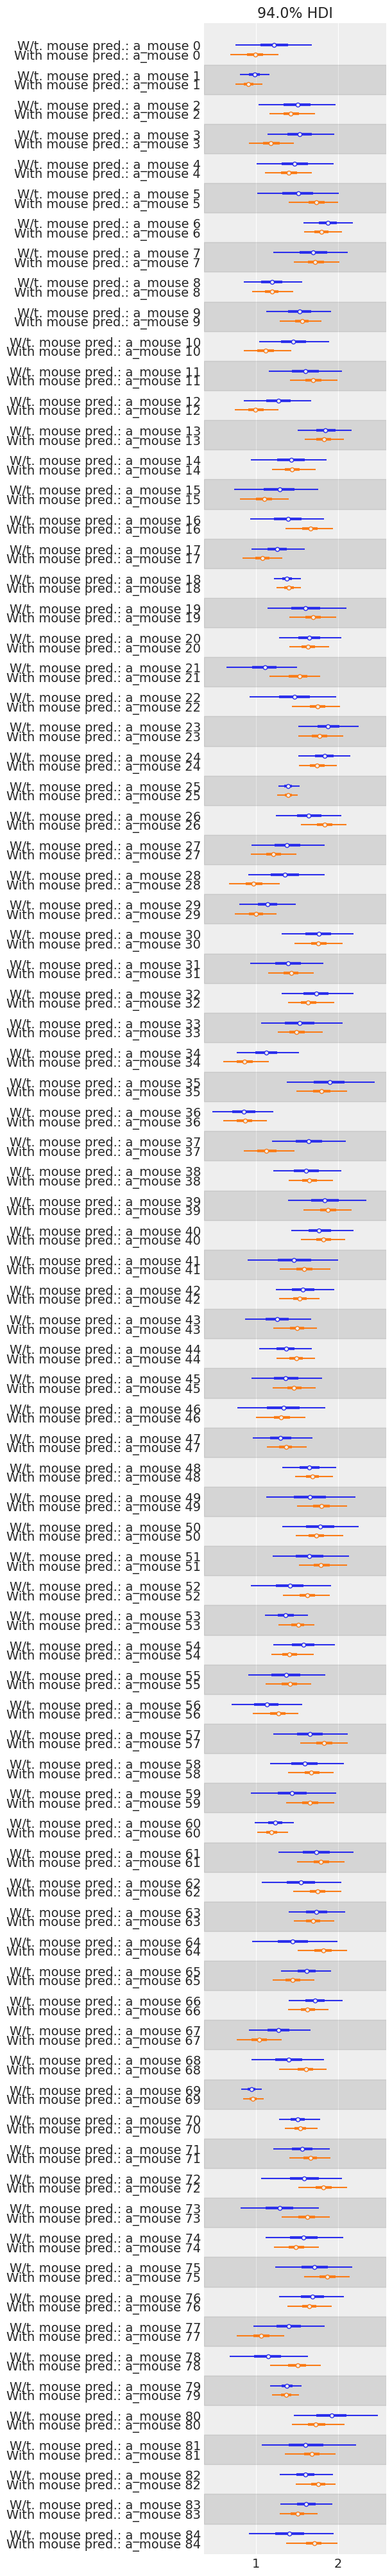

In [55]:
# HIDE CODE

az.plot_forest(
    [varying_intercept_trace, hierarchical_intercept_trace], 
    model_names=["W/t. mouse pred.", "With mouse pred."], 
    var_names=["a_mouse"], 
    combined=True,
    figsize=(6, 40)
);

In [56]:
# HIDE CODE

avg_no_stim = srrs_mn.groupby('mouse')['no_stim'].mean().rename(mouse_lookup).values

with pm.Model() as contextual_effect:
    # Hyperpriors:
    g = pm.Normal('g', mu=0., sigma=10., shape=3)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts velocity model:
    a = pm.Deterministic('a', g[0] + g[1] * u + g[2] * avg_no_stim)
    za_mouse = pm.Normal('za_mouse', mu=0., sigma=1., shape=n_mice)
    a_mouse = pm.Deterministic('a_mouse', a + za_mouse * sigma_a)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.)
    
    mouse_idx = pm.intX(pm.Data('mouse_idx', mouse))
    no_stim_vals = pm.Data('no_stim_vals', no_stim)
    # Expected value per mouse:
    theta = a_mouse[mouse_idx] + b * no_stim_vals
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    pm.model_to_graphviz(contextual_effect)    
    
    contextual_effect_trace = pm.sample(1000, tune=8000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(contextual_effect_trace, var_names=["g"], round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigma, b, za_mouse, sigma_a, g]


Sampling 2 chains for 8_000 tune and 1_000 draw iterations (16_000 + 2_000 draws total) took 123 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
g[0]  1.43  0.05    1.34     1.52       0.00      0.0   1081.39  1073.39   
g[1]  0.70  0.08    0.54     0.87       0.00      0.0   1909.14  1888.01   
g[2]  0.39  0.19    0.02     0.75       0.01      0.0   1318.05  1288.03   

      ess_bulk  ess_tail  r_hat  
g[0]   1096.02   1160.41    1.0  
g[1]   1911.85   1498.90    1.0  
g[2]   1320.44   1164.73    1.0

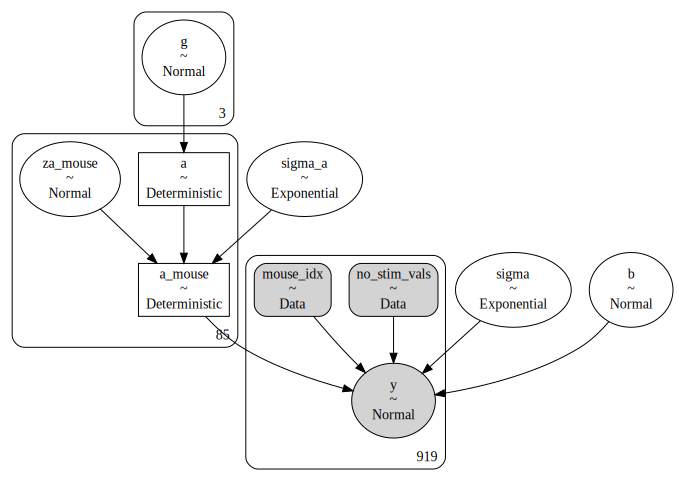

In [57]:
# HIDE CODE

pm.model_to_graphviz(contextual_effect)

In [58]:
# HIDE CODE

mouse_lookup["ST LOUIS"]

69

/home/m/anaconda3/envs/tf/lib/python3.6/site-packages/arviz/data/base.py:153: UserWarning: More chains (2000) than draws (919). Passed array should have shape (chains, draws, *shape)
  UserWarning,


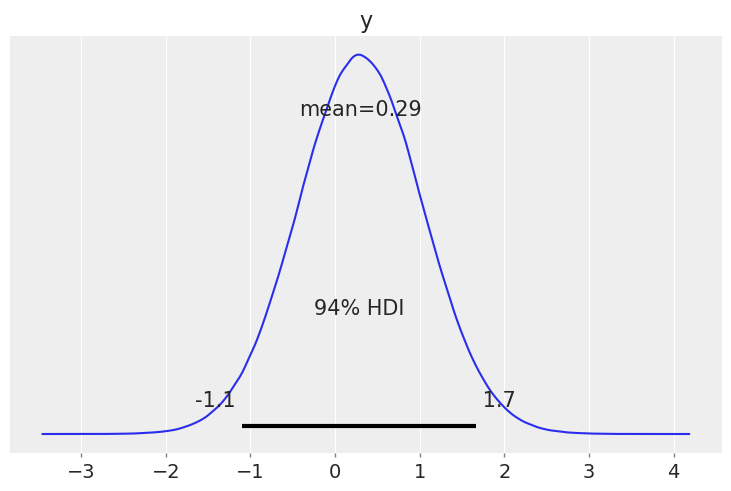

In [59]:
# HIDE CODE

with contextual_effect:
    pm.set_data({
        "mouse_idx": np.array([69]),
        "no_stim_vals": np.array([1])
    })
    stl_pred = pm.sample_posterior_predictive(contextual_effect_trace, random_seed=RANDOM_SEED)
az.plot_posterior(stl_pred);

In [60]:
# HIDE CODE
